In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [17]:
print(tf.config.list_physical_devices("GPU"))
print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0


In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

# Paths
data_dir = r"C:\Users\Jaero\Desktop\Programming\Plant_Disease_Practice 1\data"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")

# Parameters
img_size = (224, 224)   # MobileNetV2 input size
batch_size = 32

# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size
)

Found 2800 files belonging to 8 classes.
Found 800 files belonging to 8 classes.
Found 400 files belonging to 8 classes.


In [19]:
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']


In [20]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def preprocess(images, labels):
    images = preprocess_input(images)  # Important for MobileNetV2
    return images, labels

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

In [21]:
from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNetV2

num_classes = len(class_names)

base_model = MobileNetV2(input_shape=(224,224,3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # Freeze base initially

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,  # set higher, early stopping will stop when needed
    callbacks=[early_stop]
)

Epoch 1/50
88/88 [==============================] - 10s 77ms/step - loss: 0.7338 - accuracy: 0.7568 - val_loss: 0.1988 - val_accuracy: 0.9550
Epoch 2/50
88/88 [==============================] - 6s 67ms/step - loss: 0.1761 - accuracy: 0.9561 - val_loss: 0.1089 - val_accuracy: 0.9787
Epoch 3/50
88/88 [==============================] - 6s 66ms/step - loss: 0.1133 - accuracy: 0.9750 - val_loss: 0.0770 - val_accuracy: 0.9837
Epoch 4/50
88/88 [==============================] - 6s 66ms/step - loss: 0.0752 - accuracy: 0.9836 - val_loss: 0.0638 - val_accuracy: 0.9837
Epoch 5/50
88/88 [==============================] - 6s 66ms/step - loss: 0.0577 - accuracy: 0.9904 - val_loss: 0.0514 - val_accuracy: 0.9900
Epoch 6/50
88/88 [==============================] - 6s 65ms/step - loss: 0.0485 - accuracy: 0.9907 - val_loss: 0.0465 - val_accuracy: 0.9900
Epoch 7/50
88/88 [==============================] - 6s 66ms/step - loss: 0.0378 - accuracy: 0.9946 - val_loss: 0.0400 - val_accuracy: 0.9925
Epoch 8/50
8

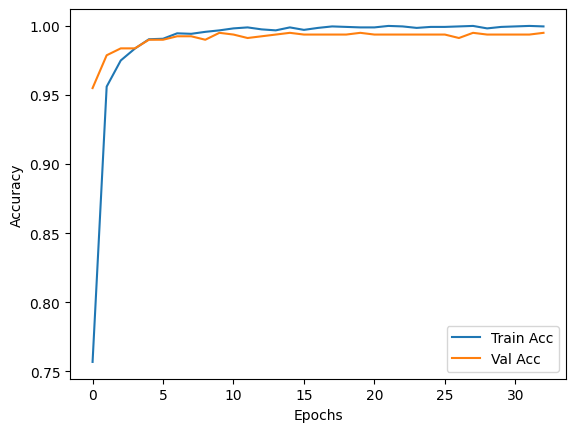

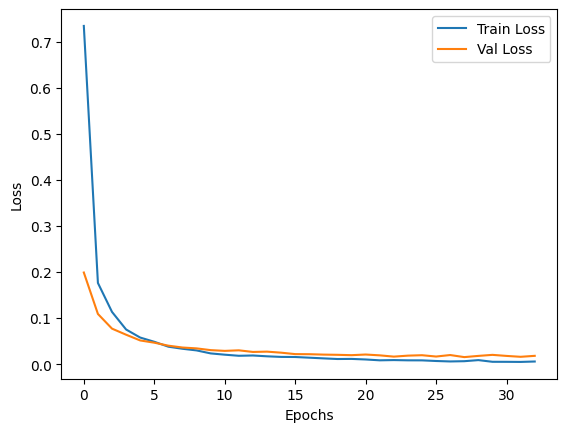

In [23]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
y_true = []
y_pred_classes = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred_classes.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred_classes = np.array(y_pred_classes)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# # Save Keras model
# model.save("mango_mobilenetv2.h5")

# # Convert to TensorFlow Lite
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# with open("mango_mobilenetv2.tflite", "wb") as f:
#     f.write(tflite_model)

1/1 [==============================] - 1s 774ms/step
                  precision    recall  f1-score   support

     Anthracnose       0.98      1.00      0.99        50
Bacterial Canker       1.00      1.00      1.00        50
  Cutting Weevil       1.00      1.00      1.00        50
        Die Back       1.00      1.00      1.00        50
      Gall Midge       0.98      0.98      0.98        50
         Healthy       1.00      0.98      0.99        50
  Powdery Mildew       1.00      1.00      1.00        50
     Sooty Mould       1.00      1.00      1.00        50

        accuracy                           0.99       400
       macro avg       1.00      0.99      0.99       400
    weighted avg       1.00      0.99      0.99       400



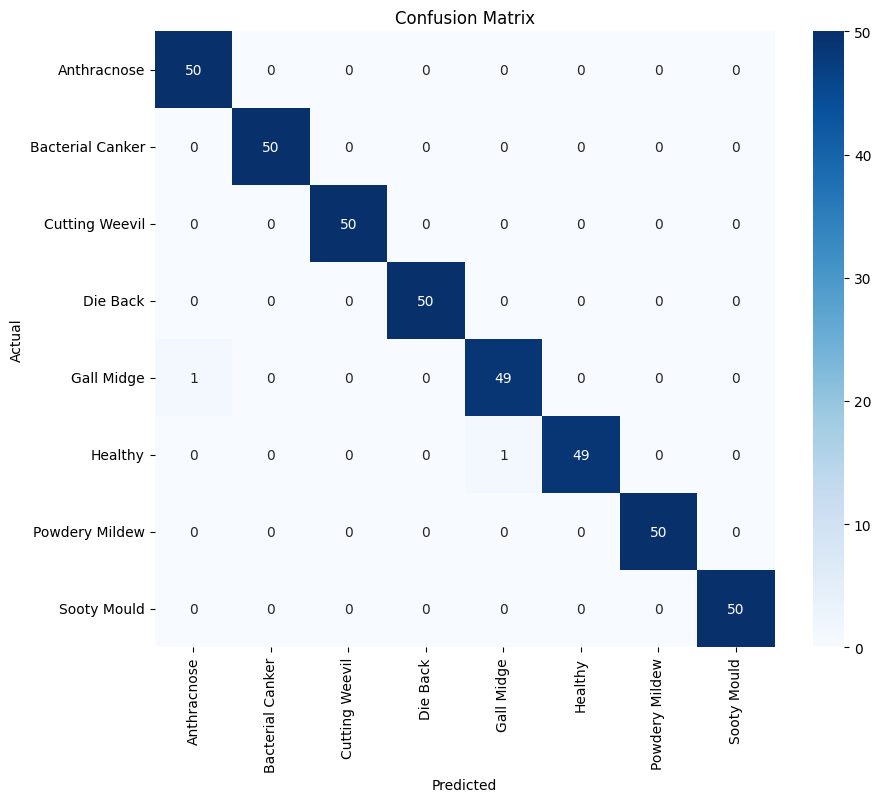

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# y_true and y_pred_classes are already correct
# class_names is your list of class labels

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [25]:
for images, labels in test_ds.take(1):
    preds = np.argmax(model.predict(images), axis=1)
    print("Predicted:", preds)
    print("Actual   :", labels.numpy())

1/1 [==============================] - 1s 834ms/step
Predicted: [4 2 1 3 5 0 4 5 3 2 6 2 2 0 1 1 0 2 4 0 7 0 1 4 6 0 5 7 2 1 6 7]
Actual   : [4 2 1 3 5 0 4 5 3 2 6 2 2 0 1 1 0 2 4 0 7 0 1 4 6 0 5 7 2 1 6 7]


In [26]:
print(class_names)
print(model.output_shape)

['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']
(None, 8)


In [29]:
# Old method
y_true_old = np.concatenate([y for x, y in test_ds], axis=0)
print("y_true_old shape:", y_true_old.shape)

# Correct method
y_true_new = []
for images, labels in test_ds:
    y_true_new.extend(labels.numpy())
y_true_new = np.array(y_true_new)
print("y_true_new shape:", y_true_new.shape)

y_true_old shape: (400,)
y_true_new shape: (400,)


First 20 y_true_old: [4 4 5 7 0 5 4 5 7 4 5 2 5 3 7 0 0 5 0 1]
First 20 y_true_new: [0 7 3 4 5 4 2 2 6 4 2 5 4 2 4 5 1 4 2 0]


In [32]:
# Save Keras model
model.save("mango_mobilenetv2.h5")

# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("mango_mobilenetv2.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Jaero\AppData\Local\Temp\tmpohx1qzu3\assets


INFO:tensorflow:Assets written to: C:\Users\Jaero\AppData\Local\Temp\tmpohx1qzu3\assets
